# Clustering

## Setup

In [ ]:
%conda install -c conda-forge numpy pandas matplotlib seaborn scipy

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score
from scipy.special import logsumexp
import pickle

In [22]:
data_pca = np.load('data/features_pca.npz')
features_pca = data_pca['features']
movieIds_pca = data_pca['movieId']

data_svd = np.load('data/features_svd.npz')
features_svd = data_svd['features']
movieIds_svd = data_svd['movieId']

data_lda = np.load('data/features_lda.npz')
features_lda = data_lda['features']
movieIds_lda = data_lda['movieId']

movies = pd.read_csv('data/train_complete.csv')
movies = pd.concat([movies, pd.read_csv('data/test_complete.csv')], ignore_index=True)

## K-means

- Industry standard for image clustering
- Fast and scalable for large datasers
- Works well when clusters are spherical and similar in size
- Easy to interpret: each movie belongs to exactly one cluster
- Suitable for poster features where visual styles form distinct groups

In [23]:
class KMeans:
    def __init__(self, n_clusters=10, max_iters=50, tol=1e-4, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        
    def fit(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        self.centroids = self._kmeans_plus_plus(X)
        self.labels_ = np.zeros(n_samples, dtype=int)
        self.inertia_ = 0.0
        
        for iteration in range(self.max_iters):
            distances = cdist(X, self.centroids, metric='euclidean')
            self.labels_ = np.argmin(distances, axis=1)
            
            new_centroids = np.array([X[self.labels_ == k].mean(axis=0) 
                                     for k in range(self.n_clusters)])
            
            if np.allclose(self.centroids, new_centroids, atol=self.tol):
                break
                
            self.centroids = new_centroids
        
        self.inertia_ = np.sum((X - self.centroids[self.labels_])**2)
        
        return self
    
    def _kmeans_plus_plus(self, X):
        n_samples = X.shape[0]
        centroids = []
        
        first_idx = np.random.randint(n_samples)
        centroids.append(X[first_idx])
        
        for _ in range(1, self.n_clusters):
            distances = cdist(X, np.array(centroids), metric='euclidean')
            min_distances = np.min(distances, axis=1)
            probabilities = min_distances ** 2
            probabilities /= probabilities.sum()
            
            next_idx = np.random.choice(n_samples, p=probabilities)
            centroids.append(X[next_idx])
        
        return np.array(centroids)
    
    def predict(self, X):
        distances = cdist(X, self.centroids, metric='euclidean')
        return np.argmin(distances, axis=1)
    
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

### Finding optimal number of clusters

#### Hint from number of genres

In [24]:
all_genres = set()

for genre_str in movies['genres'].dropna():
    all_genres.update(genre_str.split('|'))

n_genres = len(all_genres)

print(f"Number of unique genres in dataset: {n_genres}")
print(f"Genres: {sorted(all_genres)}")

Number of unique genres in dataset: 19
Genres: ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


#### Testing 

In [25]:
n_range = range(max(n_genres // 2, 2), int(n_genres * 1.5) + 1, 1)

reduction_methods = {
    'PCA': (features_pca, movieIds_pca),
    'SVD': (features_svd, movieIds_svd),
    'LDA': (features_lda, movieIds_lda)
}

avg_silhouettes = []

for n in n_range:
    print(f"Evaluating for n={n}")
    n_silhouettes = []

    for method, (features, movieIds) in reduction_methods.items():
        kmeans = KMeans(n_clusters=n)
        labels = kmeans.fit_predict(features)
        sil = silhouette_score(features, labels)
        n_silhouettes.append(sil)
        print(f"    {method}: {sil:.4f}")
    
    avg = np.mean(n_silhouettes)
    avg_silhouettes.append(np.mean(n_silhouettes))
    print(f"Avg: {avg:.4f}\n")

optimal_n_kmeans = list(n_range)[np.argmax(avg_silhouettes)]
print(f"Optimal number of clusters for K-means based on average Silhouette score: {optimal_n_kmeans}")

Evaluating for n=9
    PCA: 0.0088
    SVD: 0.0163
    LDA: 0.0743
Avg: 0.0332

Evaluating for n=10
    PCA: 0.0093
    SVD: 0.0142
    LDA: 0.0816
Avg: 0.0351

Evaluating for n=11
    PCA: 0.0124
    SVD: 0.0104
    LDA: 0.0888
Avg: 0.0372

Evaluating for n=12
    PCA: 0.0106
    SVD: 0.0117
    LDA: 0.0981
Avg: 0.0401

Evaluating for n=13
    PCA: 0.0107
    SVD: 0.0125
    LDA: 0.0995
Avg: 0.0409

Evaluating for n=14
    PCA: 0.0111
    SVD: 0.0110
    LDA: 0.1036
Avg: 0.0419

Evaluating for n=15
    PCA: 0.0115
    SVD: 0.0107
    LDA: 0.1100
Avg: 0.0441

Evaluating for n=16
    PCA: 0.0114
    SVD: 0.0110
    LDA: 0.0953
Avg: 0.0392

Evaluating for n=17
    PCA: 0.0126
    SVD: 0.0107
    LDA: 0.0844
Avg: 0.0359

Evaluating for n=18
    PCA: 0.0132
    SVD: 0.0109
    LDA: 0.0792
Avg: 0.0344

Evaluating for n=19
    PCA: 0.0123
    SVD: 0.0101
    LDA: 0.0808
Avg: 0.0344

Evaluating for n=20
    PCA: 0.0113
    SVD: 0.0089
    LDA: 0.0796
Avg: 0.0333

Evaluating for n=21
    PCA: 

#### Results

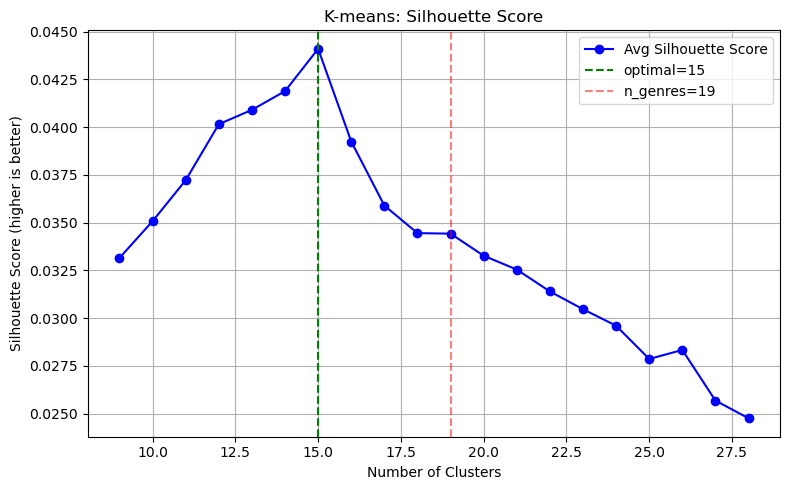

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(list(n_range), avg_silhouettes, marker='o', color='blue', label='Avg Silhouette Score')
plt.axvline(optimal_n_kmeans, color='green', linestyle='--', label=f'optimal={optimal_n_kmeans}')
plt.axvline(n_genres, color='red', linestyle='--', alpha=0.5, label=f'n_genres={n_genres}')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score (higher is better)')
plt.title('K-means: Silhouette Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Final models

In [27]:
kmeans_pca = KMeans(n_clusters=optimal_n_kmeans, max_iters=500)
kmeans_pca.fit(features_pca)

kmeans_svd = KMeans(n_clusters=optimal_n_kmeans, max_iters=500)
kmeans_svd.fit(features_svd)

kmeans_lda = KMeans(n_clusters=optimal_n_kmeans, max_iters=500)
kmeans_lda.fit(features_lda)

with open('models/kmeans_pca.pkl', 'wb') as f:
    pickle.dump(kmeans_pca, f)

with open('models/kmeans_svd.pkl', 'wb') as f:
    pickle.dump(kmeans_svd, f)

with open('models/kmeans_lda.pkl', 'wb') as f:
    pickle.dump(kmeans_lda, f)

print("K-means models saved to 'models/' directory.")

K-means models saved to 'models/' directory.


## GMM

- Probabilistic assignments: captures uncertainty in cluster memebership
- Flexible cluster shapes: can model elliptical clusters
- Better for overlapping styles: a poster can have mixed characteristics
- Natural for movie posters: genres often blend (action-comedy, scifi-fi-drama, etc)
- Provides probability scores useful for recommendations

In [28]:
class GaussianMixtureModel:
    def __init__(self, n_components=10, max_iters=50, tol=1e-4,
                 reg_covar=1e-6, covariance_type='full', random_state=42):
        self.n_components = n_components
        self.max_iters = max_iters
        self.tol = tol
        self.reg_covar = reg_covar
        self.covariance_type = covariance_type
        self.random_state = random_state

    def fit(self, X):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        kmeans = KMeans(n_clusters=self.n_components, random_state=self.random_state)
        kmeans.fit(X)
        self.means_ = kmeans.centroids.copy()
        labels = kmeans.labels_

        self.weights_ = np.array([np.mean(labels == k) for k in range(self.n_components)])
        self.covariances_ = np.zeros((self.n_components, n_features, n_features))

        for k in range(self.n_components):
            diff = X[labels == k] - self.means_[k]
            if diff.shape[0] > 1:
                cov = np.cov(diff.T)
            else:
                cov = np.eye(n_features)
            cov += np.eye(n_features) * self.reg_covar
            if self.covariance_type == 'diag':
                cov = np.diag(np.diag(cov))
            self.covariances_[k] = cov

        log_likelihood_old = -np.inf
        for iteration in range(self.max_iters):
            responsibilities = self._e_step(X)
            self._m_step(X, responsibilities)
            log_likelihood = self._compute_log_likelihood(X)

            if np.abs(log_likelihood - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood

        self.log_likelihood_ = log_likelihood
        self.labels_ = self.predict(X)
        return self

    def _e_step(self, X):
        n_samples = X.shape[0]
        log_prob = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            try:
                log_prob[:, k] = np.log(self.weights_[k] + 1e-12) + \
                    multivariate_normal.logpdf(
                        X, mean=self.means_[k],
                        cov=self.covariances_[k],
                        allow_singular=True
                    )
            except Exception:
                log_prob[:, k] = -1e10

        log_sum = logsumexp(log_prob, axis=1, keepdims=True)
        log_resp = log_prob - log_sum
        responsibilities = np.exp(log_resp)
        return responsibilities

    def _m_step(self, X, responsibilities):
        n_samples, n_features = X.shape
        Nk = responsibilities.sum(axis=0) + 1e-12

        self.weights_ = Nk / n_samples
        self.means_ = (responsibilities.T @ X) / Nk[:, None]

        for k in range(self.n_components):
            diff = X - self.means_[k]
            weighted = responsibilities[:, k][:, None] * diff
            cov = (weighted.T @ diff) / Nk[k]
            cov += np.eye(n_features) * self.reg_covar
            if self.covariance_type == 'diag':
                cov = np.diag(np.diag(cov))
            self.covariances_[k] = cov

    def _compute_log_likelihood(self, X):
        n_samples = X.shape[0]
        log_prob = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            try:
                log_prob[:, k] = np.log(self.weights_[k] + 1e-12) + \
                    multivariate_normal.logpdf(
                        X, mean=self.means_[k],
                        cov=self.covariances_[k],
                        allow_singular=True
                    )
            except Exception:
                log_prob[:, k] = -1e10

        return np.sum(logsumexp(log_prob, axis=1))

    def predict(self, X):
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

    def predict_proba(self, X):
        return self._e_step(X)


### Finding optimal number of clusters for GMM

We use the same hint from the number of genres

#### Results

In [29]:
n_range = range(max(2, n_genres // 2), int(n_genres * 1.5) + 1, 1)

reduction_methods = {
    'PCA': (features_pca, movieIds_pca),
    'SVD': (features_svd, movieIds_svd),
    'LDA': (features_lda, movieIds_lda)
}

avg_bics = []

for n in n_range:
    print(f"Evaluating for n={n}")
    n_bics = []

    for method, (features, movieIds) in reduction_methods.items():
        gmm = GaussianMixtureModel(n_components=n, covariance_type='diag')
        gmm.fit(features)

        log_likelihood = gmm._compute_log_likelihood(features)
        N, D = features.shape

        n_params = n * (2 * D) + (n - 1)

        bic = -2 * log_likelihood + n_params * np.log(N)

        n_bics.append(bic)
        print(f"    {method}: {bic:.2f}")

    avg_bic = np.mean(n_bics)
    avg_bics.append(avg_bic)
    print(f"Avg: {avg_bic:.2f}\n")

optimal_n_gmm = list(n_range)[np.argmin(avg_bics)]

print(f"Optimal number of clusters for GMM based on BIC score: {optimal_n_gmm}")


Evaluating for n=9
    PCA: 3300508.07
    SVD: 3299645.83
    LDA: 432994.41
Avg: 2344382.77

Evaluating for n=10
    PCA: 3300346.63
    SVD: 3300023.61
    LDA: 432398.58
Avg: 2344256.27

Evaluating for n=11
    PCA: 3300360.41
    SVD: 3298832.72
    LDA: 430663.72
Avg: 2343285.62

Evaluating for n=12
    PCA: 3300404.98
    SVD: 3298252.26
    LDA: 429090.95
Avg: 2342582.73

Evaluating for n=13
    PCA: 3300338.26
    SVD: 3298476.83
    LDA: 428292.66
Avg: 2342369.25

Evaluating for n=14
    PCA: 3300084.99
    SVD: 3298619.16
    LDA: 427513.30
Avg: 2342072.48

Evaluating for n=15
    PCA: 3300454.27
    SVD: 3299106.03
    LDA: 426947.56
Avg: 2342169.29

Evaluating for n=16
    PCA: 3300597.34
    SVD: 3299745.39
    LDA: 427174.88
Avg: 2342505.87

Evaluating for n=17
    PCA: 3300772.48
    SVD: 3299282.42
    LDA: 427299.59
Avg: 2342451.50

Evaluating for n=18
    PCA: 3301180.49
    SVD: 3299802.09
    LDA: 427526.24
Avg: 2342836.28

Evaluating for n=19
    PCA: 3301654.59
 

#### Results

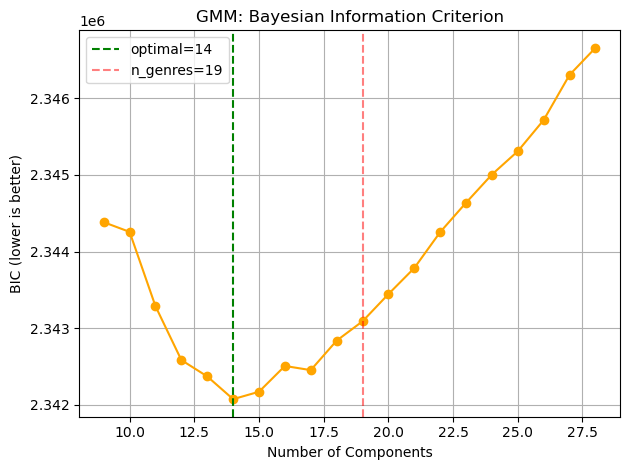

In [30]:
plt.plot(n_range, avg_bics, marker='o', color='orange')
plt.axvline(optimal_n_gmm, color='green', linestyle='--', label=f'optimal={optimal_n_gmm}')
plt.axvline(n_genres, color='red', linestyle='--', alpha=0.5, label=f'n_genres={n_genres}')
plt.xlabel('Number of Components')
plt.ylabel('BIC (lower is better)')
plt.title('GMM: Bayesian Information Criterion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Final Models

In [31]:
gmm_pca = GaussianMixtureModel(n_components=optimal_n_gmm, max_iters=500)
gmm_pca.fit(features_pca)

gmm_svd = GaussianMixtureModel(n_components=optimal_n_gmm, max_iters=500)
gmm_svd.fit(features_svd)

gmm_lda = GaussianMixtureModel(n_components=optimal_n_gmm, max_iters=500)
gmm_lda.fit(features_lda)

with open('models/gmm_pca.pkl', 'wb') as f:
    pickle.dump(gmm_pca, f)

with open('models/gmm_svd.pkl', 'wb') as f:
    pickle.dump(gmm_svd, f)

with open('models/gmm_lda.pkl', 'wb') as f:
    pickle.dump(gmm_lda, f)

print("GMM models saved to 'models/' directory.")

GMM models saved to 'models/' directory.
